In [1]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("ColabSpark").getOrCreate()

print(spark)

In [3]:
import random
import pandas as pd

def generate_patient_data(n=10000):
    data = []
    for i in range(n):
        patient = {
            "patient_id": i+1,
            "age": random.randint(18, 90),
            "gender": random.choice(["Male", "Female"]),
            "bp": f"{random.randint(90, 160)}/{random.randint(60, 100)}",
            "sugar": random.randint(70, 180),
            "cholesterol": random.randint(125, 250),
            "haemoglobin": round(random.uniform(12, 18), 1),
            "bmi": round(random.uniform(18, 35), 1)
        }
        data.append(patient)

    return pd.DataFrame(data)

df = generate_patient_data(10000)
df.to_csv("patients.csv", index=False)
print("10,000 patient profiles generated!")

10,000 patient profiles generated!


In [4]:
df_spark = spark.read.csv("patients.csv", header=True, inferSchema=True)
df_spark.show(5)

+----------+---+------+------+-----+-----------+-----------+----+
|patient_id|age|gender|    bp|sugar|cholesterol|haemoglobin| bmi|
+----------+---+------+------+-----+-----------+-----------+----+
|         1| 81|  Male| 93/83|  131|        236|       12.9|20.8|
|         2| 81|Female|110/60|   83|        224|       13.6|34.7|
|         3| 33|Female|107/96|  148|        147|       13.2|31.9|
|         4| 64|Female|124/98|   83|        182|       15.3|31.3|
|         5| 69|  Male|145/66|  169|        204|       12.5|34.7|
+----------+---+------+------+-----+-----------+-----------+----+
only showing top 5 rows



In [5]:
df_spark.createOrReplaceTempView("patients")

spark.sql("""
    SELECT
        AVG(bp) AS avg_bp,
        AVG(sugar) AS avg_sugar,
        AVG(cholesterol) AS avg_cholesterol,
        AVG(haemoglobin) AS avg_haemoglobin
    FROM patients
""").show()

+------+---------+---------------+------------------+
|avg_bp|avg_sugar|avg_cholesterol|   avg_haemoglobin|
+------+---------+---------------+------------------+
|  NULL| 125.3937|       186.7577|14.990640000000022|
+------+---------+---------------+------------------+



In [6]:
df_spark.describe().show()

+-------+------------------+------------------+------+-------+----------------+-----------------+------------------+------------------+
|summary|        patient_id|               age|gender|     bp|           sugar|      cholesterol|       haemoglobin|               bmi|
+-------+------------------+------------------+------+-------+----------------+-----------------+------------------+------------------+
|  count|             10000|             10000| 10000|  10000|           10000|            10000|             10000|             10000|
|   mean|            5000.5|           54.2875|  NULL|   NULL|        125.3937|         186.7577|14.990640000000022|26.469290000000136|
| stddev|2886.8956799071675|21.000279639197522|  NULL|   NULL|32.1625767538042|36.33104987787333|1.7326876842238828| 4.921606253725674|
|    min|                 1|                18|Female|100/100|              70|              125|              12.0|              18.0|
|    max|             10000|                90| 

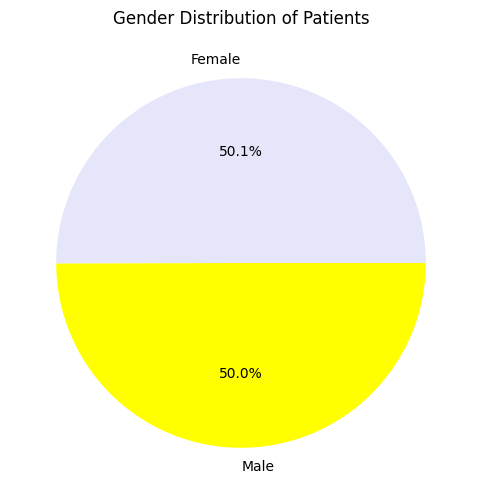

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

df_pandas = df_spark.toPandas()

gender_counts = df_pandas['gender'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors=['lavender', 'yellow'])
plt.title("Gender Distribution of Patients")
plt.show()

<ipython-input-8-d32a62537bdc>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="sugar", data=df_pandas, palette="Blues")


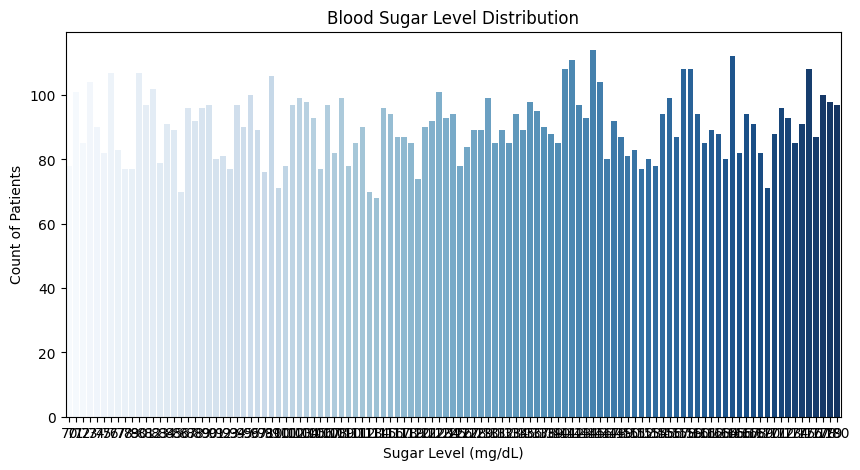

In [8]:
plt.figure(figsize=(10, 5))
sns.countplot(x="sugar", data=df_pandas, palette="Blues")
plt.title("Blood Sugar Level Distribution")
plt.xlabel("Sugar Level (mg/dL)")
plt.ylabel("Count of Patients")
plt.show()

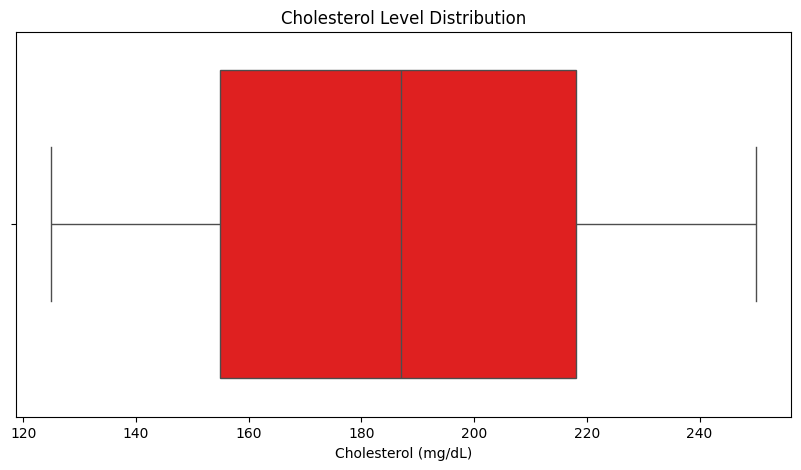

In [9]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_pandas["cholesterol"], color="red")
plt.title("Cholesterol Level Distribution")
plt.xlabel("Cholesterol (mg/dL)")
plt.show()

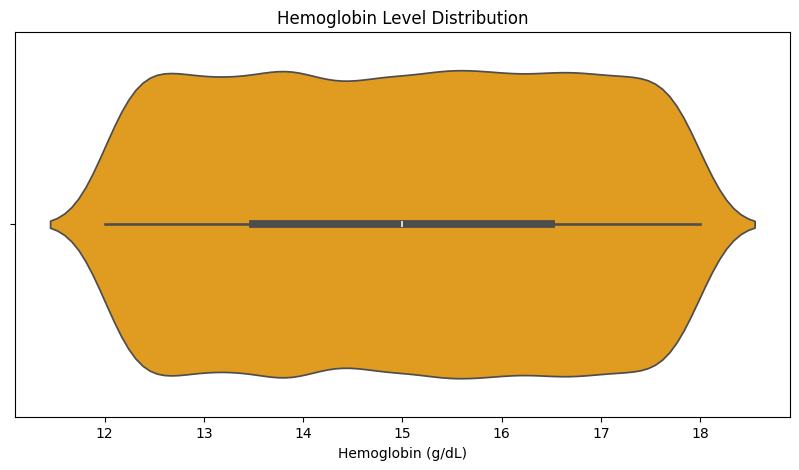

In [10]:
plt.figure(figsize=(10, 5))
sns.violinplot(x=df_pandas["haemoglobin"], color="orange")
plt.title("Hemoglobin Level Distribution")
plt.xlabel("Hemoglobin (g/dL)")
plt.show()

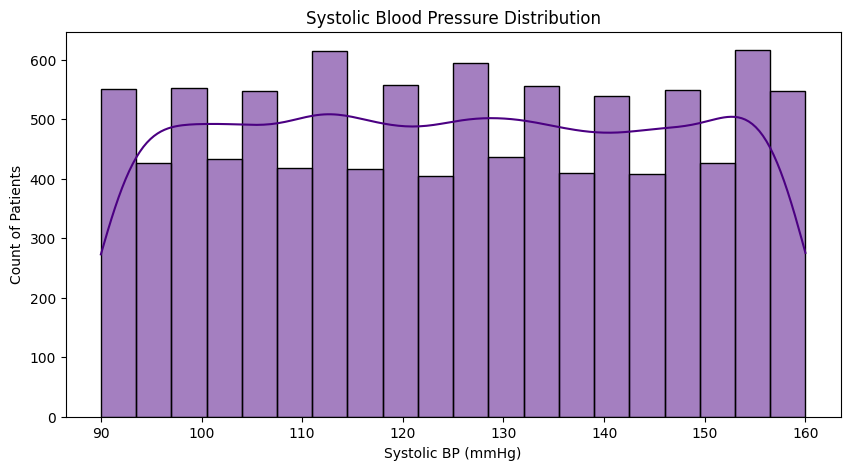

In [22]:
df_pandas[['systolic', 'diastolic']] = df_pandas['bp'].str.split('/', expand=True).astype(int)

plt.figure(figsize=(10, 5))
sns.histplot(df_pandas["systolic"], bins=20, kde=True, color="indigo")
plt.title("Systolic Blood Pressure Distribution")
plt.xlabel("Systolic BP (mmHg)")
plt.ylabel("Count of Patients")
plt.show()

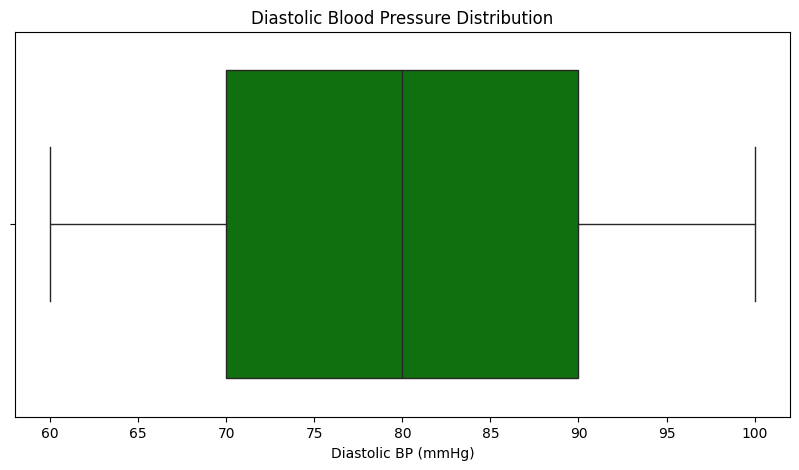

In [19]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_pandas["diastolic"], color="green")
plt.title("Diastolic Blood Pressure Distribution")
plt.xlabel("Diastolic BP (mmHg)")
plt.show()

<ipython-input-20-c318b4b41c1d>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_pandas["MAP"], shade=True, color="blue")


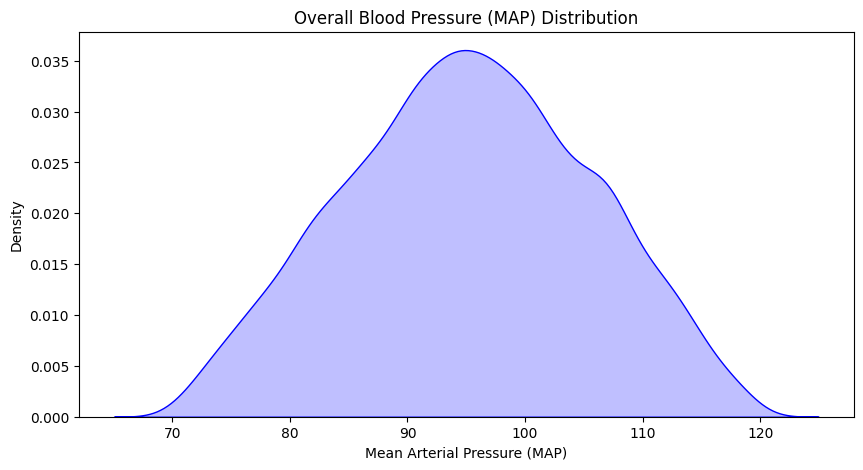

In [20]:
df_pandas["MAP"] = (df_pandas["systolic"] + (2 * df_pandas["diastolic"])) / 3

plt.figure(figsize=(10, 5))
sns.kdeplot(df_pandas["MAP"], shade=True, color="blue")
plt.title("Overall Blood Pressure (MAP) Distribution")
plt.xlabel("Mean Arterial Pressure (MAP)")
plt.ylabel("Density")
plt.show()

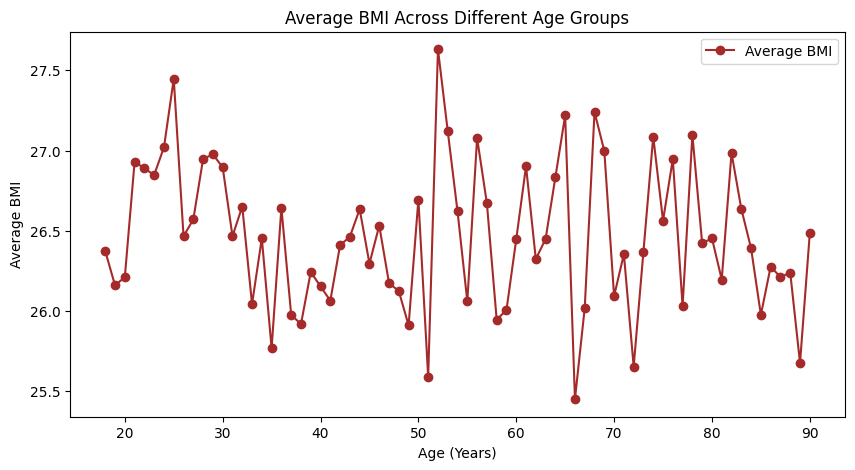

In [16]:
bmi_trend = df_pandas.groupby("age")["bmi"].mean().reset_index()
plt.figure(figsize=(10, 5))
plt.plot(bmi_trend["age"], bmi_trend["bmi"], marker='o', linestyle='-', color="brown", label="Average BMI")
plt.xlabel("Age (Years)")
plt.ylabel("Average BMI")
plt.title("Average BMI Across Different Age Groups")
plt.legend()
plt.show()